In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline


In [4]:
df = pd.read_csv('datasets/final-preprocessed-imputed-compas-df.csv')

In [5]:
df = df[['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree',
          'decile_score', 'v_decile_score',
          'age', 'income', 'jail_duration', 'MaritalStatus',
          'RiskOfViolence_DecileScore', 'RiskOfFailureToAppear_DecileScore', # we do not include RiskOfRecidivism_DecileScore since we have decile_score
          'event']]

X = df.drop('event', axis=1)
y = df['event']

In [6]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=500, solver='lbfgs'))
])
#df.head()

In [7]:
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

rus = RandomUnderSampler(random_state=123)
X_train, y_train = rus.fit_resample(X_train, y_train)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [8]:
X.columns

Index(['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
       'c_charge_degree', 'decile_score', 'v_decile_score', 'age', 'income',
       'jail_duration', 'MaritalStatus', 'RiskOfViolence_DecileScore',
       'RiskOfFailureToAppear_DecileScore'],
      dtype='object')

In [9]:
print(X_train.dtypes)

juv_fel_count                        float64
juv_misd_count                       float64
juv_other_count                      float64
priors_count                         float64
c_charge_degree                      float64
decile_score                         float64
v_decile_score                       float64
age                                  float64
income                                object
jail_duration                        float64
MaritalStatus                         object
RiskOfViolence_DecileScore           float64
RiskOfFailureToAppear_DecileScore    float64
dtype: object


In [10]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count',
                                                   'c_charge_degree',
                                                   'decile_score',
                                                   'v_decile_score', 'age',
                                                   'jail_duration',
                                                   'RiskOfViolence_DecileScore',
                                                   'RiskOfFailureToAppear_DecileScore']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['income',
                                                   'MaritalStatus'])])),
                ('classifier', LogisticRegression(max_iter=500))])

In [11]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 64.80%


In [12]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1124  603]
 [  69  113]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.65      0.77      1727
         1.0       0.16      0.62      0.25       182

    accuracy                           0.65      1909
   macro avg       0.55      0.64      0.51      1909
weighted avg       0.87      0.65      0.72      1909



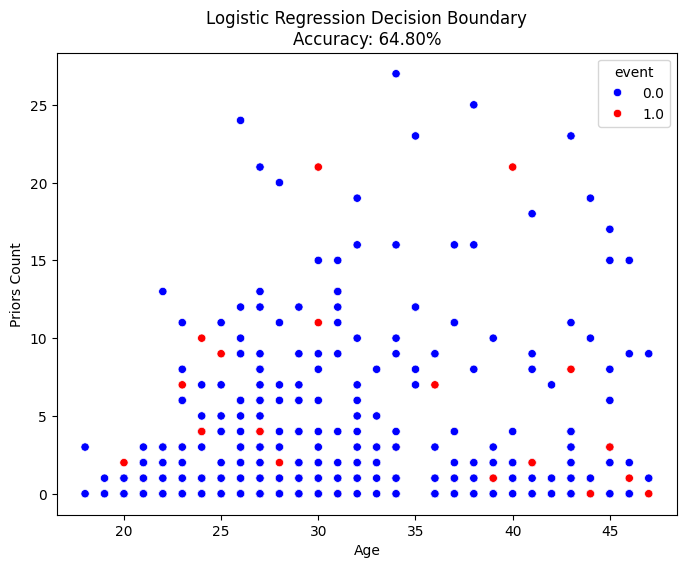

In [13]:
# Visualize the decision boundary with accuracy information
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test['age'], y=X_test['priors_count'], hue=y_test, palette={
				0: 'blue', 1: 'red'}, marker='o')
plt.xlabel("Age")
plt.ylabel("Priors Count")
plt.title("Logistic Regression Decision Boundary\nAccuracy: {:.2f}%".format(
	accuracy * 100))
plt.legend(title="event", loc="upper right")
plt.show()


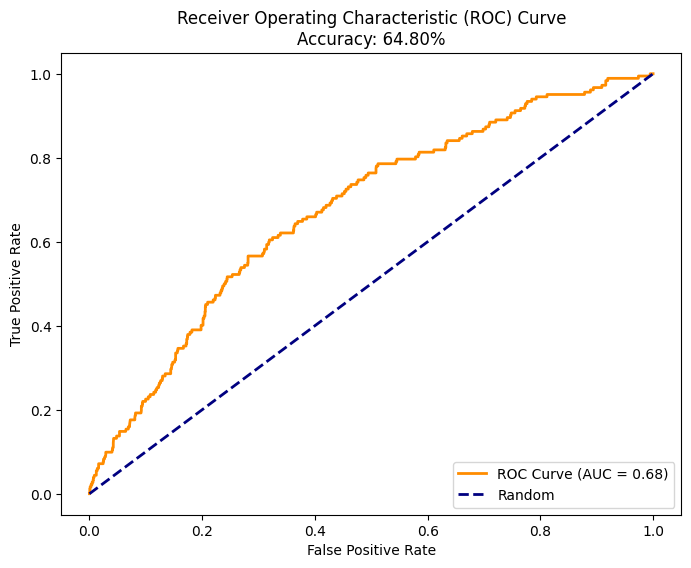

In [14]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
		label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
	accuracy * 100))
plt.legend(loc="lower right")
plt.show()


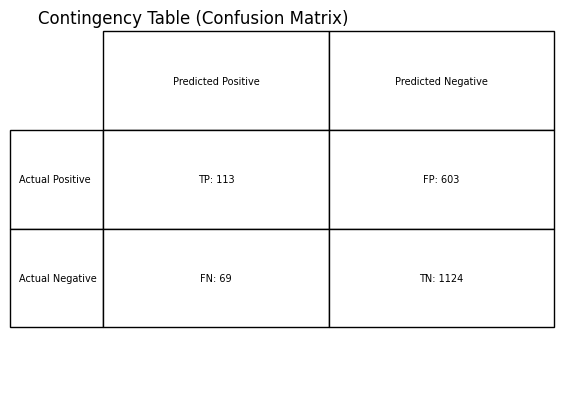

In [15]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

plt.subplot(1, 2, 2)
plt.axis('off')
table_data = [[f"TP: {tp}", f"FP: {fp}"],
              [f"FN: {fn}", f"TN: {tn}"]]
table = plt.table(cellText=table_data,
                  cellLoc='center',
                  loc='center',
                  colLabels=["Predicted Positive", "Predicted Negative"],
                  rowLabels=["Actual Positive", "Actual Negative"],
                  bbox=[0.1, 0.2, 2, 0.8])

plt.title("Contingency Table (Confusion Matrix)")
plt.show()

# Get the values of the false positives to analyze them-

In [16]:
import numpy as np
import pandas as pd

#ONLY WORKS IF RACE IS INCLUDED

# Assume y_test is your true labels and y_prob is the predicted probabilities
# and your threshold is 0.5 (you can adjust as necessary)

# X_test = X_test.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)

# threshold = 0.5
# y_pred = (y_prob >= threshold).astype(int)

# # Identify false positives: actual label is 0, but prediction is 1.
# # If X_test is a pandas DataFrame containing your test features, you can do:
# false_positive_mask = (y_test == 0) & (y_pred == 1)
# false_positives = X_test[false_positive_mask]

# Now, false_positives is a DataFrame containing all features for the false positive cases.
# print("False Positives:")
# print(false_positives)

# print("frequency")

# print("-------------------------------------")

# print("African American:", false_positives['race_African-American'].sum())
# print("Asian:", false_positives['race_Asian'].sum())
# print("Hispanic:", false_positives['race_Hispanic'].sum())
# print("Native American:", false_positives['race_Native American'].sum())
# print("Other:", false_positives['race_Other'].sum())

# print("-------------------------------------")

# print("\nSummary Statistics for False Positives:")
# print(false_positives['race_Asian'].describe())
# print("-------------------------------------")
# print(false_positives['race_Hispanic'].describe())
# print("-------------------------------------")
# print(false_positives['race_Native American'].describe())
# print("-------------------------------------")
# print(false_positives['race_Other'].describe())
# print("-------------------------------------")
# print(false_positives['race_African-American'].describe())


In [17]:
# #african american
# aa_df = df[df['race_African-American'] == 1]
# print(aa_df['is_violent_recid'].value_counts())
# #print(aa_df['is_violent_recid'].unique())

# #asian
# asian_df = df[df['race_Asian'] == 1]
# print(asian_df['is_violent_recid'].value_counts())

# #hispanic
# h_df = df[df['race_Hispanic'] == 1]
# print(h_df['is_violent_recid'].value_counts())

## **SHAP for Logistic Regression**
The code for the SHAP values/plots has been based on Lab 3

In [18]:
import shap

trained_model = model.named_steps['classifier']

X_train_processed = model.named_steps['preprocessor'].transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=model.named_steps['preprocessor'].get_feature_names_out())
X_test_processed = model.named_steps['preprocessor'].transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=model.named_steps['preprocessor'].get_feature_names_out())

lreg_explainer = shap.LinearExplainer(trained_model,X_train_processed)

c:\Users\wissa\Documents\coding\Crew6\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
shap.initjs()

shap_values = lreg_explainer.shap_values(X_test_processed)
shap.force_plot(lreg_explainer.expected_value, shap_values, X_test_processed)

AttributeError: 'numpy.float64' object has no attribute 'standard_normal'

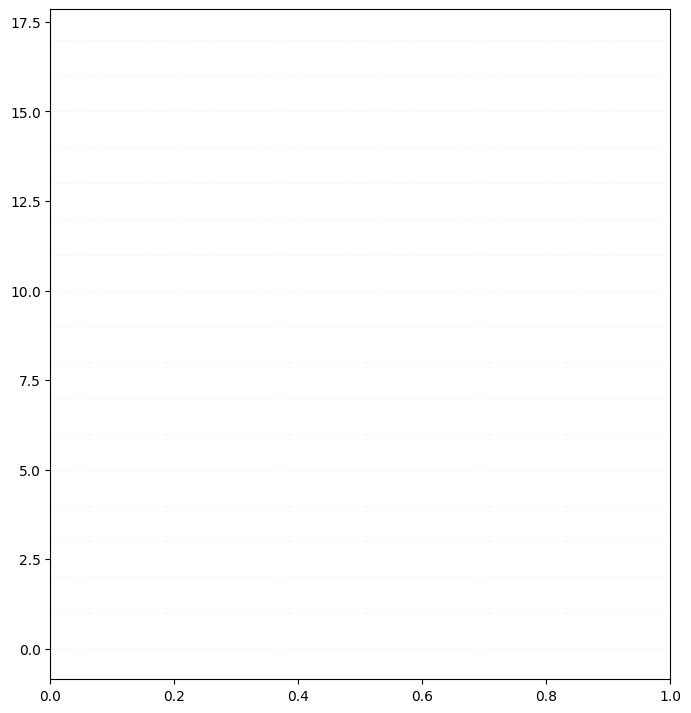

In [20]:
shap_values = lreg_explainer.shap_values(X_test_processed)
shap.summary_plot(shap_values, X_test_processed, plot_type="violin", max_display=100)

#is violent recid is causing bias against african americans

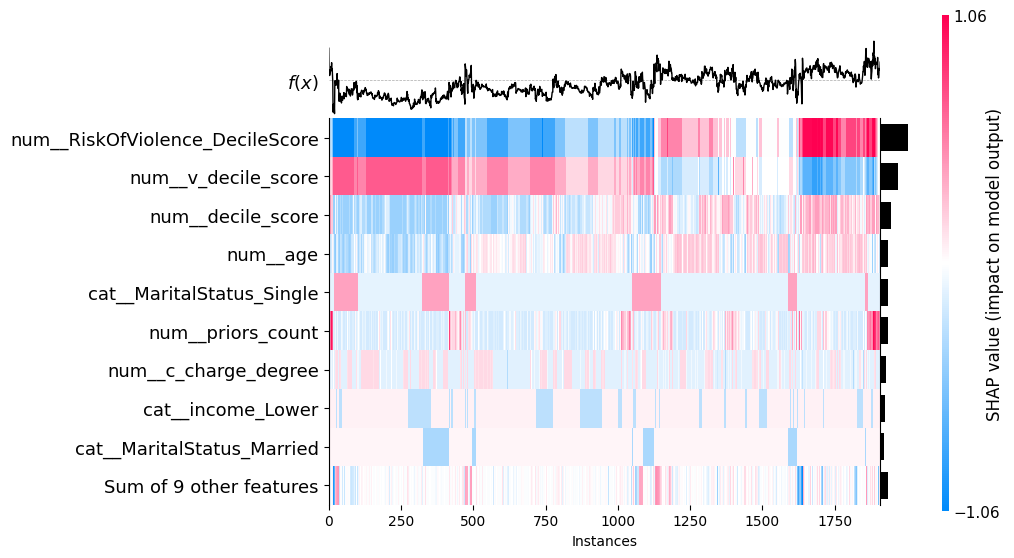

<Axes: xlabel='Instances'>

In [21]:
class_index = 0

shap_values = lreg_explainer(X_test_processed)
shap.plots.heatmap(shap_values[:,:,class_index])

# PDP

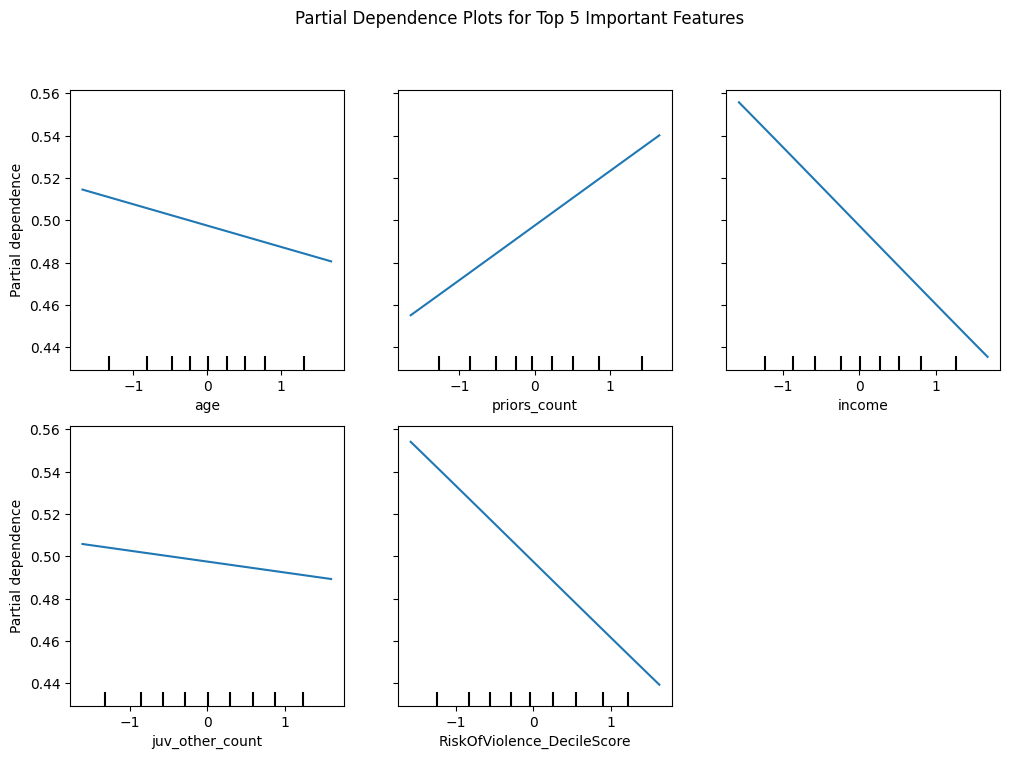

In [22]:

# Simulate dataset (adjust to your actual dataset)
numerical_cols = ['age', 'priors_count', 'income', 'juv_other_count', 'RiskOfViolence_DecileScore']  # Top 5 features
np.random.seed(42)
X = pd.DataFrame(np.random.randn(500, len(numerical_cols)), columns=numerical_cols)
y = np.random.randint(0, 2, size=500)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=500, solver='lbfgs')
log_reg.fit(X_train_scaled, y_train)

# Generate PDP for the top 5 important features
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(log_reg, X_train_scaled, features=list(range(len(numerical_cols))),
                                        feature_names=numerical_cols, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 5 Important Features")
plt.show()


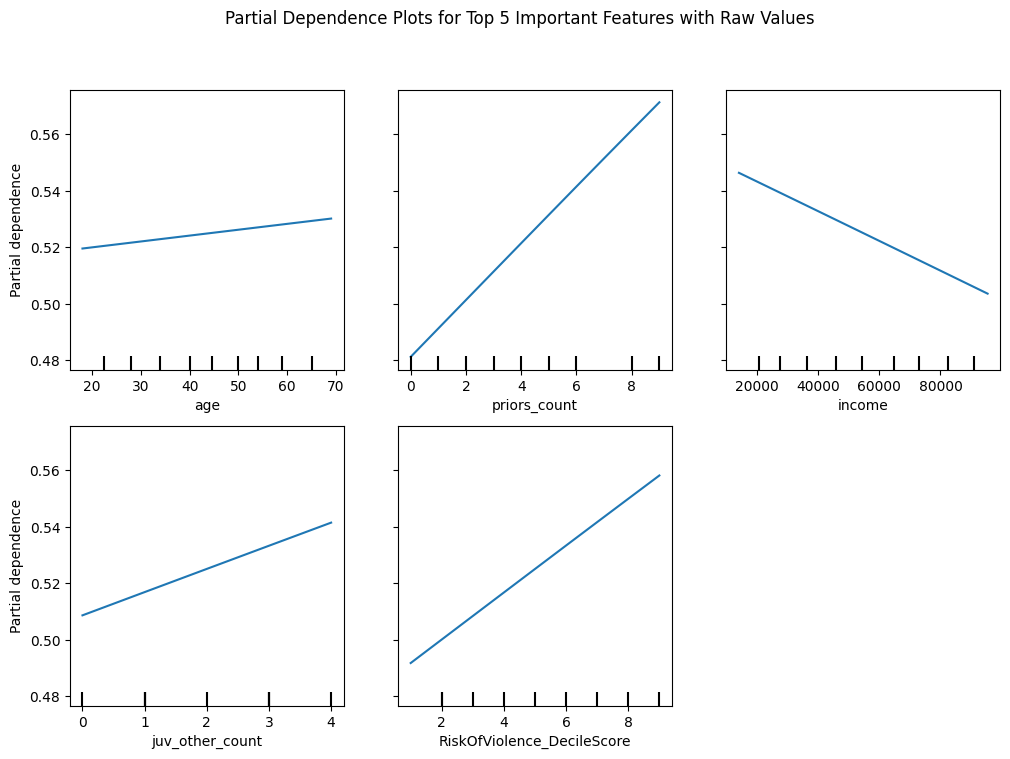

In [23]:

numerical_cols = ['age', 'priors_count', 'income', 'juv_other_count', 'RiskOfViolence_DecileScore']  # Top 5 features
np.random.seed(42)
X = pd.DataFrame({
    'age': np.random.randint(18, 70, 500),
    'priors_count': np.random.randint(0, 10, 500),
    'income': np.random.randint(10000, 100000, 500),
    'juv_other_count': np.random.randint(0, 5, 500),
    'RiskOfViolence_DecileScore': np.random.randint(1, 10, 500)
})
y = np.random.randint(0, 2, size=500)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model on raw data
log_reg = LogisticRegression(max_iter=500, solver='lbfgs')
log_reg.fit(X_train, y_train)

# Generate PDP for the top 5 important features
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(log_reg, X_train, features=numerical_cols, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 5 Important Features with Raw Values")
plt.show()
